## Inference Demo

### Objective

This notebook demonstrates how the trained CNN model can be used for inference
on a single unseen image. The goal is to show the complete prediction pipeline,
including preprocessing, forward pass, and interpretation of the output.

No training is performed in this notebook.

In [64]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

## Load Trained Model

The CNN model trained previously is loaded from disk.

In [65]:
MODEL_PATH = PROJECT_ROOT / "models" / "cnn_happiness_model.keras"

model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       270,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,221 (3.10 MB)

 Trainable params: 271,073 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 542,148 (2.07 MB)

## Define Preprocessing Function

The preprocessing pipeline mirrors the one used during training:
- grayscale conversion
- resizing to 48x48
- normalization
- channel dimension addition

In [66]:
def preprocess_image(image_path, image_size=(48, 48)):
    img = Image.open(image_path).convert("L")
    img = img.resize(image_size)
    img = np.asarray(img, dtype=np.float32) / 255.0
    img = img[..., np.newaxis]          # add channel
    img = np.expand_dims(img, axis=0)   # add batch dimension
    return img

## Load Image for Inference

Any external image containing a face can be used.
The model has not seen this image during training.

In [67]:
IMAGE_PATH = PROJECT_ROOT / "data" / "my_test"/ "1_happy_vlad.jpg"

img_input = preprocess_image(IMAGE_PATH)
img_input.shape

(1, 48, 48, 1)

## Run Inference

The model outputs a probability value in the range [0, 1],
representing the likelihood of the happy class.

In [68]:
probability = model.predict(img_input)[0][0]
prediction = "Happy" if probability >= 0.5 else "Non-happy"

probability, prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


(np.float32(0.38660184), 'Non-happy')

## Visualization

The input image is displayed together with the model prediction.

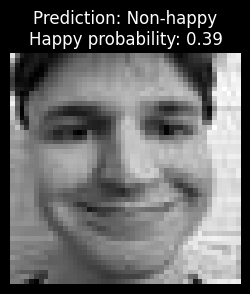

In [69]:
img_display = Image.open(IMAGE_PATH).convert("L")

plt.figure(figsize=(3, 3))
plt.imshow(img_display, cmap="gray")
plt.axis("off")
plt.title(f"Prediction: {prediction}\nHappy probability: {probability:.2f}")
plt.show()

## Batch Inference on Custom Folder

This section applies the trained CNN model to all images located in a custom
directory using the same preprocessing pipeline.

In [70]:
TEST_DIR = PROJECT_ROOT / "data" / "my_test"

image_paths = sorted([
    p for p in TEST_DIR.iterdir()
    if p.suffix.lower() in [".jpg", ".jpeg", ".png"]
])

len(image_paths)

6

### Folder-Level Prediction Setup

The images collected above are processed sequentially using the same
preprocessing function defined earlier. Each image is treated as an
independent inference sample, ensuring that no information is shared
across predictions.

In [71]:
def predict_folder(model, image_paths, threshold=0.5):
    outputs = []

    for img_path in image_paths:
        img_input = preprocess_image(img_path)
        prob = model.predict(img_input, verbose=0)[0][0]
        label = "Happy" if prob >= threshold else "Non-happy"

        outputs.append((img_path, prob, label))

    return outputs

### Running Batch Inference

The function below applies the trained CNN model to each image in the
custom folder and returns both the predicted class label and the
associated probability score.

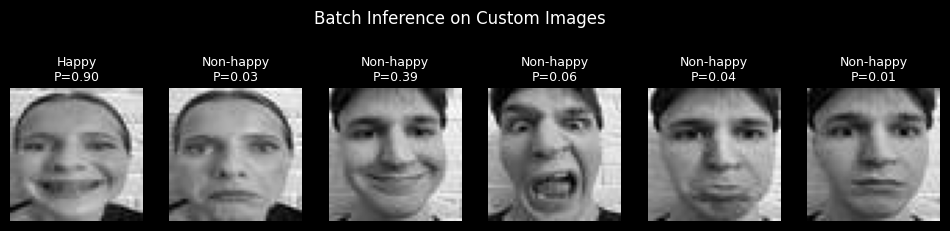

In [72]:
results = predict_folder(model, image_paths)

plt.figure(figsize=(12, 3))

for i, (path, prob, label) in enumerate(results):
    img = Image.open(path).convert("L")

    plt.subplot(1, len(results), i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"{label}\nP={prob:.2f}", fontsize=9)

plt.suptitle("Batch Inference on Custom Images")
plt.show()

### Visualizing Predictions

The predicted labels and probabilities are visualized alongside the
input images to provide an intuitive understanding of the model's
behavior on unseen data.

## Interpretation and Limitations

- The predictions are based on visual patterns learned from the FER2013 dataset
  and do not represent an objective measure of emotional state.
- The model assumes that input images are already cropped and aligned around
  the face; no face detection is performed.
- Model outputs may be sensitive to variations in lighting, pose, and image
  resolution.
- Happiness is treated as a binary visual classification problem rather than a
  psychological or affective assessment.

## Stop Condition

This notebook concludes the end-to-end pipeline of the project, demonstrating
how a trained model can be applied to unseen data using a consistent and
reproducible inference process.